BI名企班，谢雅楠，20201206

## 1. 说明解决方案思路
基于周期因子进行时间序列预测  
可以基于每月的规律（1-30号的平均流量）* 周期因子  
Step1，计算周期因子（weekday）  
Step2，计算每日（1号-30号）均值，即1号的平均流量，2号的平均流量 …  
Step3，统计星期几（weekday）在每日（day）出现的频次  
Step4，基于周期因子获得加权均值，得到每日的base（去掉周期因子的影响）  
Step5，根据每日的base和周期因子进行预测  


## 2. 完成代码

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import datetime

In [2]:
## read in data
data = pd.read_csv('user_balance_table.csv')

In [3]:
## add timestamp

def add_timestamp(data):
    data['report_date'] = pd.to_datetime(data['report_date'], format='%Y%m%d')
    
    data['day'] = data['report_date'].dt.day
    data['month'] = data['report_date'].dt.month
    data['year'] = data['report_date'].dt.year
    data['week'] = data['report_date'].dt.week
    data['weekday'] = data['report_date'].dt.weekday
    
    return data

data = add_timestamp(data)
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,share_amt,category1,category2,category3,category4,day,month,year,week,weekday
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,5,8,2014,32,1
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,8,8,2014,32,4
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,11,8,2014,33,0
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,14,8,2014,33,3
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,...,2,NaN,NaN,NaN,NaN,17,8,2014,33,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,...,61,NaN,NaN,NaN,NaN,25,8,2014,35,0
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,...,60,0.0,0.0,0.0,12500.0,31,8,2014,35,6
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,...,2297,NaN,NaN,NaN,NaN,24,7,2014,30,3
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,...,2298,NaN,NaN,NaN,NaN,27,7,2014,30,6


In [4]:
data['weekday'].value_counts()  #0 monday

6    410701
5    408824
4    407509
3    405907
2    404159
1    402536
0    400785
Name: weekday, dtype: int64

In [5]:
# 筛选2014-04-01之后的数据作为平稳数据进行学习
def get_total_balance(data, begin):
    df_temp = data.copy()
    df_temp = df_temp.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
    
    df_temp.reset_index(inplace=True)
    df_temp = df_temp[(df_temp['report_date'] >= begin)]
#     print(df_temp)
    return df_temp

In [6]:
total_balance = get_total_balance(data, '2014-03-01')
total_balance

<ipython-input-5-2973634f7682>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_temp = df_temp.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()


,report_date,total_purchase_amt,total_redeem_amt
243,2014-03-01,362865580,211279011
244,2014-03-02,276202230,246199417
245,2014-03-03,505305862,513017360
246,2014-03-04,524146340,250562978
247,2014-03-05,454295491,209072753
...,...,...,...
422,2014-08-27,302194801,468164147
423,2014-08-28,245082751,297893861
424,2014-08-29,267554713,273756380
425,2014-08-30,199708772,196374134


In [7]:
# 生成测试数据
def generate_test_data(data):
    total_balance = data.copy()
    start = datetime.datetime(2014,9,1)
    end = datetime.datetime(2014,10,1)
    
    test_data = []
    while start != end:
        temp = [start, np.nan, np.nan]
        test_data.append(temp)
        start += datetime.timedelta(days=1)
        
    testdata = pd.DataFrame(test_data)
    testdata.columns = total_balance.columns
    
    total_balance = pd.concat([total_balance, testdata], axis=0)
    return total_balance



In [8]:
total_balance = generate_test_data(total_balance)
total_balance

,report_date,total_purchase_amt,total_redeem_amt
243,2014-03-01,362865580.0,211279011.0
244,2014-03-02,276202230.0,246199417.0
245,2014-03-03,505305862.0,513017360.0
246,2014-03-04,524146340.0,250562978.0
247,2014-03-05,454295491.0,209072753.0
...,...,...,...
25,2014-09-26,NaN,NaN
26,2014-09-27,NaN,NaN
27,2014-09-28,NaN,NaN
28,2014-09-29,NaN,NaN


In [9]:
total_balance = add_timestamp(total_balance)
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
243,2014-03-01,362865580.0,211279011.0,1,3,2014,9,5
244,2014-03-02,276202230.0,246199417.0,2,3,2014,9,6
245,2014-03-03,505305862.0,513017360.0,3,3,2014,10,0
246,2014-03-04,524146340.0,250562978.0,4,3,2014,10,1
247,2014-03-05,454295491.0,209072753.0,5,3,2014,10,2
...,...,...,...,...,...,...,...,...
25,2014-09-26,NaN,NaN,26,9,2014,39,4
26,2014-09-27,NaN,NaN,27,9,2014,39,5
27,2014-09-28,NaN,NaN,28,9,2014,39,6
28,2014-09-29,NaN,NaN,29,9,2014,40,0


In [10]:
temp =  total_balance.copy()  ## 存储备份
total_balance = temp.copy()  # 原始备份

### 周期因子 weekday

In [11]:
# total_balance = total_balance[['report_date', 'total_purchase_amt', 'total_redeem_amt']]

weekday_weight = total_balance[['weekday', 'total_purchase_amt', 'total_redeem_amt']].groupby('weekday', as_index=False).mean()
weekday_weight = weekday_weight.rename(columns={'total_purchase_amt': 'purchase_weekday',
                              'total_redeem_amt': 'redeem_weekday'})

weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,3.273693e+08,3.456808e+08
1,1,3.340518e+08,3.221266e+08
2,2,3.213877e+08,3.181960e+08
3,3,3.146910e+08,2.821480e+08
4,4,2.492893e+08,2.680463e+08
5,5,1.958666e+08,1.840544e+08
6,6,1.966477e+08,2.093138e+08


In [12]:
weekday_weight['purchase_weekday'] /= np.mean(total_balance['total_purchase_amt'])
weekday_weight['redeem_weekday'] /= np.mean(total_balance['total_redeem_amt'])

weekday_weight

,weekday,purchase_weekday,redeem_weekday
0,0,1.185411,1.257964
1,1,1.209608,1.172248
2,2,1.163752,1.157944
3,3,1.139503,1.026762
4,4,0.902682,0.975445
5,5,0.709237,0.669791
6,6,0.712065,0.761712


In [13]:
total_balance = pd.merge(total_balance, weekday_weight, on='weekday', how='left')
total_balance

,report_date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday,purchase_weekday,redeem_weekday
0,2014-03-01,362865580.0,211279011.0,1,3,2014,9,5,0.709237,0.669791
1,2014-03-02,276202230.0,246199417.0,2,3,2014,9,6,0.712065,0.761712
2,2014-03-03,505305862.0,513017360.0,3,3,2014,10,0,1.185411,1.257964
3,2014-03-04,524146340.0,250562978.0,4,3,2014,10,1,1.209608,1.172248
4,2014-03-05,454295491.0,209072753.0,5,3,2014,10,2,1.163752,1.157944
...,...,...,...,...,...,...,...,...,...,...
209,2014-09-26,NaN,NaN,26,9,2014,39,4,0.902682,0.975445
210,2014-09-27,NaN,NaN,27,9,2014,39,5,0.709237,0.669791
211,2014-09-28,NaN,NaN,28,9,2014,39,6,0.712065,0.761712
212,2014-09-29,NaN,NaN,29,9,2014,40,0,1.185411,1.257964


### 日期因子 day

In [14]:
# 统计周一到周日在1-30号中出现的频次
weekday_count = total_balance[['report_date', 'day', 'weekday']].groupby(['day', 'weekday'], as_index=False).count()
weekday_count = pd.merge(weekday_count, weekday_weight, on='weekday')
weekday_count


,day,weekday,report_date,purchase_weekday,redeem_weekday
0,1,0,1,1.185411,1.257964
1,2,0,1,1.185411,1.257964
2,3,0,1,1.185411,1.257964
3,4,0,1,1.185411,1.257964
4,5,0,1,1.185411,1.257964
...,...,...,...,...,...
179,25,2,1,1.163752,1.157944
180,26,2,1,1.163752,1.157944
181,27,2,1,1.163752,1.157944
182,28,2,1,1.163752,1.157944


In [15]:
len(np.unique(total_balance['month']))

7

In [16]:
weekday_count['purchase_weekday'] = weekday_count['purchase_weekday'] * weekday_count['report_date'] / len(np.unique(total_balance['month'])) 
weekday_count['redeem_weekday'] = weekday_count['redeem_weekday'] * weekday_count['report_date'] / len(np.unique(total_balance['month'])) 


In [17]:
day_rate = weekday_count.drop(['weekday', 'report_date'], axis=1).groupby('day', as_index=False).sum()
day_rate

,day,purchase_weekday,redeem_weekday
0,1,1.009731,1.005167
1,2,1.006644,1.021864
2,3,1.037011,1.010455
3,4,1.030815,1.046789
4,5,1.002776,0.989992
5,6,0.935559,0.932230
6,7,0.999723,1.015369
7,8,1.009731,1.005167
8,9,1.006644,1.021864
9,10,1.037011,1.010455


In [18]:
# day mean

day_mean = total_balance[['day', 'total_purchase_amt', 'total_redeem_amt']].groupby('day', as_index=False).mean()
day_mean

,day,total_purchase_amt,total_redeem_amt
0,1,3.253391e+08,2.347676e+08
1,2,2.481255e+08,2.186074e+08
2,3,2.994808e+08,2.968247e+08
3,4,3.159802e+08,2.925598e+08
4,5,3.286272e+08,2.552484e+08
5,6,2.998453e+08,2.460958e+08
6,7,2.836725e+08,2.374837e+08
7,8,2.918664e+08,2.475255e+08
8,9,2.856603e+08,2.440269e+08
9,10,3.446347e+08,2.593854e+08


In [19]:
day_pred = pd.merge(day_mean, day_rate, on='day', how='left')
day_pred['total_purchase_amt'] /= day_pred['purchase_weekday']
day_pred['total_redeem_amt'] /= day_pred['redeem_weekday']
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday
0,1,3.222038e+08,2.335608e+08,1.009731,1.005167
1,2,2.464879e+08,2.139300e+08,1.006644,1.021864
2,3,2.887923e+08,2.937537e+08,1.037011,1.010455
3,4,3.065345e+08,2.794832e+08,1.030815,1.046789
4,5,3.277176e+08,2.578287e+08,1.002776,0.989992
5,6,3.204986e+08,2.639860e+08,0.935559,0.932230
6,7,2.837511e+08,2.338892e+08,0.999723,1.015369
7,8,2.890537e+08,2.462531e+08,1.009731,1.005167
8,9,2.837750e+08,2.388057e+08,1.006644,1.021864
9,10,3.323346e+08,2.567017e+08,1.037011,1.010455


In [20]:
for index, row in day_pred.iterrows():
    if row['day'] == 31:
        break
    day_pred.loc[index, 'report_date'] = pd.to_datetime('2014/09/'+str(int(row['day'])))
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday,report_date
0,1,3.222038e+08,2.335608e+08,1.009731,1.005167,2014-09-01
1,2,2.464879e+08,2.139300e+08,1.006644,1.021864,2014-09-02
2,3,2.887923e+08,2.937537e+08,1.037011,1.010455,2014-09-03
3,4,3.065345e+08,2.794832e+08,1.030815,1.046789,2014-09-04
4,5,3.277176e+08,2.578287e+08,1.002776,0.989992,2014-09-05
5,6,3.204986e+08,2.639860e+08,0.935559,0.932230,2014-09-06
6,7,2.837511e+08,2.338892e+08,0.999723,1.015369,2014-09-07
7,8,2.890537e+08,2.462531e+08,1.009731,1.005167,2014-09-08
8,9,2.837750e+08,2.388057e+08,1.006644,1.021864,2014-09-09
9,10,3.323346e+08,2.567017e+08,1.037011,1.010455,2014-09-10


In [21]:
# base*factors

day_pred['weekday'] = day_pred['report_date'].dt.weekday
day_pred

,day,total_purchase_amt,total_redeem_amt,purchase_weekday,redeem_weekday,report_date,weekday
0,1,3.222038e+08,2.335608e+08,1.009731,1.005167,2014-09-01,0.0
1,2,2.464879e+08,2.139300e+08,1.006644,1.021864,2014-09-02,1.0
2,3,2.887923e+08,2.937537e+08,1.037011,1.010455,2014-09-03,2.0
3,4,3.065345e+08,2.794832e+08,1.030815,1.046789,2014-09-04,3.0
4,5,3.277176e+08,2.578287e+08,1.002776,0.989992,2014-09-05,4.0
5,6,3.204986e+08,2.639860e+08,0.935559,0.932230,2014-09-06,5.0
6,7,2.837511e+08,2.338892e+08,0.999723,1.015369,2014-09-07,6.0
7,8,2.890537e+08,2.462531e+08,1.009731,1.005167,2014-09-08,0.0
8,9,2.837750e+08,2.388057e+08,1.006644,1.021864,2014-09-09,1.0
9,10,3.323346e+08,2.567017e+08,1.037011,1.010455,2014-09-10,2.0


In [22]:
day_pred = day_pred[['day', 'total_purchase_amt', 'total_redeem_amt', 'report_date', 'weekday']]

In [23]:
day_pred = pd.merge(day_pred, weekday_weight, on='weekday')
day_pred

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_weekday,redeem_weekday
0,1,3.222038e+08,2.335608e+08,2014-09-01,0.0,1.185411,1.257964
1,8,2.890537e+08,2.462531e+08,2014-09-08,0.0,1.185411,1.257964
2,15,2.929654e+08,2.290269e+08,2014-09-15,0.0,1.185411,1.257964
3,22,2.406857e+08,2.599297e+08,2014-09-22,0.0,1.185411,1.257964
4,29,2.419552e+08,2.677531e+08,2014-09-29,0.0,1.185411,1.257964
5,2,2.464879e+08,2.139300e+08,2014-09-02,1.0,1.209608,1.172248
6,9,2.837750e+08,2.388057e+08,2014-09-09,1.0,1.209608,1.172248
7,16,3.123351e+08,3.058029e+08,2014-09-16,1.0,1.209608,1.172248
8,23,2.267902e+08,2.569529e+08,2014-09-23,1.0,1.209608,1.172248
9,30,2.377294e+08,2.874474e+08,2014-09-30,1.0,1.209608,1.172248


In [24]:
day_pred['total_purchase_amt'] *= day_pred['purchase_weekday']
day_pred['total_redeem_amt'] *= day_pred['redeem_weekday']
day_pred

,day,total_purchase_amt,total_redeem_amt,report_date,weekday,purchase_weekday,redeem_weekday
0,1,3.819439e+08,2.938111e+08,2014-09-01,0.0,1.185411,1.257964
1,8,3.426474e+08,3.097775e+08,2014-09-08,0.0,1.185411,1.257964
2,15,3.472844e+08,2.881076e+08,2014-09-15,0.0,1.185411,1.257964
3,22,2.853115e+08,3.269821e+08,2014-09-22,0.0,1.185411,1.257964
4,29,2.868163e+08,3.368237e+08,2014-09-29,0.0,1.185411,1.257964
5,2,2.981538e+08,2.507790e+08,2014-09-02,1.0,1.209608,1.172248
6,9,3.432566e+08,2.799395e+08,2014-09-09,1.0,1.209608,1.172248
7,16,3.778032e+08,3.584768e+08,2014-09-16,1.0,1.209608,1.172248
8,23,2.743273e+08,3.012125e+08,2014-09-23,1.0,1.209608,1.172248
9,30,2.875595e+08,3.369596e+08,2014-09-30,1.0,1.209608,1.172248


In [25]:
day_pred = day_pred.sort_values('report_date')[['report_date', 'total_purchase_amt', 'total_redeem_amt']]
day_pred

,report_date,total_purchase_amt,total_redeem_amt
0,2014-09-01,3.819439e+08,2.938111e+08
5,2014-09-02,2.981538e+08,2.507790e+08
10,2014-09-03,3.360825e+08,3.401504e+08
14,2014-09-04,3.492969e+08,2.869627e+08
18,2014-09-05,2.958247e+08,2.514977e+08
22,2014-09-06,2.273095e+08,1.768153e+08
26,2014-09-07,2.020493e+08,1.781561e+08
1,2014-09-08,3.426474e+08,3.097775e+08
6,2014-09-09,3.432566e+08,2.799395e+08
11,2014-09-10,3.867549e+08,2.972462e+08


In [26]:
day_pred['report_date'] = day_pred['report_date'].apply(lambda x: str(x).replace('-', '')[0:8])

In [27]:
day_pred

,report_date,total_purchase_amt,total_redeem_amt
0,20140901,3.819439e+08,2.938111e+08
5,20140902,2.981538e+08,2.507790e+08
10,20140903,3.360825e+08,3.401504e+08
14,20140904,3.492969e+08,2.869627e+08
18,20140905,2.958247e+08,2.514977e+08
22,20140906,2.273095e+08,1.768153e+08
26,20140907,2.020493e+08,1.781561e+08
1,20140908,3.426474e+08,3.097775e+08
6,20140909,3.432566e+08,2.799395e+08
11,20140910,3.867549e+08,2.972462e+08


In [28]:
day_pred.to_csv('rule_base.csv', index=False, header=None)

## 3. 提交结果
score = 130.6812
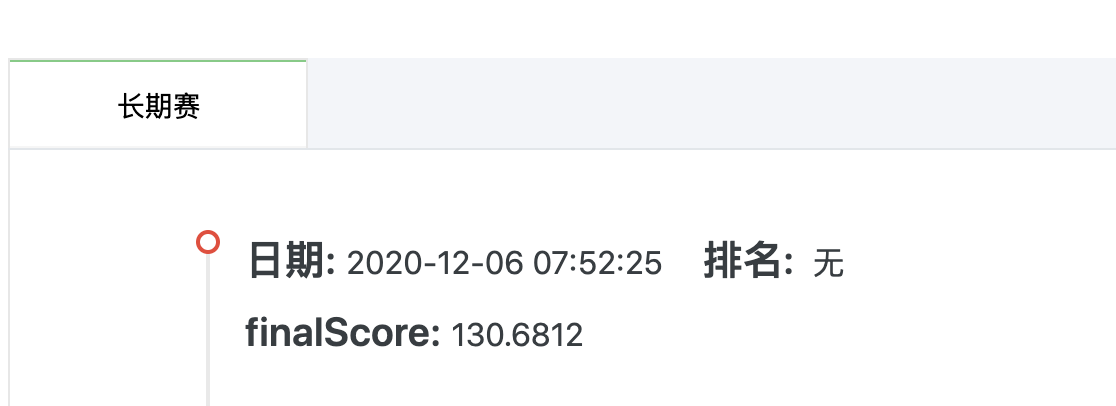